In [ ]:
#CHANGES to test-3
# added MAPE, RMSE 
#Also data is from mostly uninterrupted time from 2013-06-11 to '2020-12-16'
#Result: MAE improved due to better data selection

#Howver, I wouldn't suggest MAPE. 
#https://stats.stackexchange.com/questions/299712/what-are-the-shortcomings-of-the-mean-absolute-percentage-error-mape

In [ ]:
#Summary


# Inputs: Storage, Inflow, Outflow, Precipitation. last 60 days. Not using level because maybe the network learns too much based on it.
# Outputs: Storage 30 days ahead
# Daily data 10 years.

In [ ]:
#To-Dos
# IMPROVE the NETWORK by running it longer, playing around with parameters such as dropout rates, number of layers
#explore corelation, data plots
#add/subtract features. - Sin/Cos(Day of Year), Year. Convert shapes/units/dimensions if needed.
#add cross-validation (since dataset is small)
#try imputing data instead of removing missing data (can use an RNN to do so also. But simpler way is to look at this blog post)
# add feature importance (SHAP)
# finally make it all in containers. so can be used for GUI

In [ ]:
#@title #####Mount Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_path = '/content/gdrive/My Drive/Colab Notebooks/wave2web/'
%cd '/content/gdrive/My Drive/Colab Notebooks/wave2web/'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/wave2web


In [ ]:
# @title ####imports
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [ ]:
#Function settings and parameters

# Data Cleaning and Visualization

In [ ]:
inputs=pd.read_csv('krs_db.csv')
inputs=inputs.drop(['inflow_simulated'], axis=1)
inputs=inputs.drop(['level'], axis=1)
inputs

,date,storage,inflow,outflow,rain
0,1/1/2011,46.42,2029,2000.0,0.103059
1,1/2/2011,46.54,3084,1490.0,0.000000
2,1/3/2011,46.64,2776,1491.0,0.000000
3,1/4/2011,46.69,2311,1491.0,0.000000
4,1/5/2011,46.70,1847,1491.0,0.000000
...,...,...,...,...,...
3648,12/27/2020,NaN,NaN,NaN,0.000000
3649,12/28/2020,NaN,NaN,NaN,0.000000
3650,12/29/2020,NaN,NaN,NaN,0.000000
3651,12/30/2020,NaN,NaN,NaN,0.000000


In [ ]:
inputs.info(), inputs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     3653 non-null   object 
 1   storage  3307 non-null   float64
 2   inflow   3307 non-null   object 
 3   outflow  3307 non-null   float64
 4   rain     3653 non-null   float64
dtypes: float64(3), object(2)
memory usage: 142.8+ KB


(None,            storage        outflow         rain
 count  3307.000000    3307.000000  3653.000000
 mean     28.048990    4844.267312     3.804885
 std      14.356327    9507.320922     7.577868
 min       0.000000       0.000000     0.000000
 25%      14.295000     715.500000     0.000000
 50%      27.380000    3703.000000     0.425903
 75%      42.090000    5160.000000     4.375793
 max      49.450000  151365.000000    97.609635)

In [ ]:
#about 10% data missing
#level, inflow has non-numeric values, hence not showing in describe()
# there seem to be not any outliers or fill values such as '-999' etc.

In [ ]:
#inputs['level']=pd.to_numeric(inputs['level'], errors='coerce')
inputs['inflow']=pd.to_numeric(inputs['inflow'], errors='coerce')
inputs['date']=pd.to_datetime(inputs['date'])
inputs.describe()

,storage,inflow,outflow,rain
count,3307.000000,3306.000000,3307.000000,3653.000000
mean,28.048990,4916.569268,4844.267312,3.804885
std,14.356327,10698.975857,9507.320922,7.577868
min,0.000000,0.000000,0.000000,0.000000
25%,14.295000,319.000000,715.500000,0.000000
50%,27.380000,1717.000000,3703.000000,0.425903
75%,42.090000,5436.500000,5160.000000,4.375793
max,49.450000,204200.000000,151365.000000,97.609635


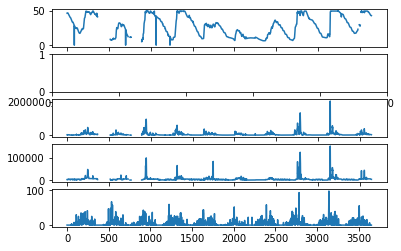

In [ ]:
#all seems ok. still plotting to see
fig,axs=plt.subplots(5)
axs[0].plot(inputs['storage'])
#axs[1].plot(inputs['level'])
axs[2].plot(inputs['inflow'])
axs[3].plot(inputs['outflow'])
axs[4].plot(inputs['rain'])

# most missing values are in a continuous range. So simply omitting for now
# is storage and level almost the same?

In [ ]:
#How to handle missing values in time-series data with strong seasonality?
# 1. simply remove the data
# 2. data imputation (method depends on keeping in mind the seasonality)

# For quick testing: https://www.kaggle.com/juejuewang/handle-missing-values-in-time-series-for-beginners
# for understanding: https://www.nature.com/articles/s41598-018-24271-9

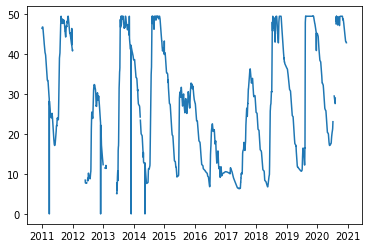

In [ ]:
plt.plot(inputs['date'], inputs['storage'])
# most missing values are in a continuous range. So simply omitting for now
#my (untested) assumption is that if we simply omit these values, there are only 2-3 places where our network will perform bad. These will be ignored in a model that does not overfit

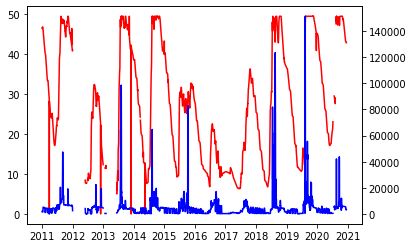

In [ ]:
fig, axs=plt.subplots()
axs.plot(inputs['date'], inputs['storage'], color='red')
axs2=axs.twinx() #data had different range. so plotted on separate y-axes
axs2.plot(inputs['date'], inputs['outflow'], color='blue')
plt.show()

In [ ]:
#Method 1: removing missing values
inputs=inputs.dropna()
inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3306 entries, 0 to 3637
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3306 non-null   datetime64[ns]
 1   storage  3306 non-null   float64       
 2   inflow   3306 non-null   float64       
 3   outflow  3306 non-null   float64       
 4   rain     3306 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 155.0 KB


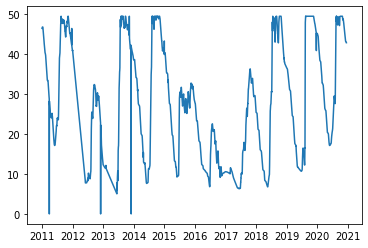

In [ ]:
plt.plot(inputs['date'], inputs['storage'])

In [ ]:
# #ETS (Error- Trend - Seasonality)
# from statsmodels.tsa.seasonal import seasonal_decompose
# # ETS Decomposition of storage and date
# subset=inputs[['storage', 'date']]
# subset=subset.set_index('date')
# subset=subset.asfreq('D')

# result = seasonal_decompose(subset['storage'], 
#                             model ='additive')
  
# # ETS plot 
# result.plot()

In [ ]:
#converting date to a better, smoother feature (since data has cyclic tendencies yearly, it is better to show that Dec-2015 is as similar to Jan-2016  as  March is to april)
#To-do: Fast Fourier Transform to find correct frequencies
#https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning

#For now, not doing anything, just finding numeric values of date, month, year

In [ ]:
# day=30.0
# month=12.0
# year=365
# inputs['Day sin'] = np.sin(inputs['day'] * (2 * np.pi / day))
# inputs['Day cos'] = np.cos(inputs['day'] * (2 * np.pi / day))
# inputs['Month sin'] = np.sin(inputs['month'] * (2 * np.pi / month))
# inputs['Month cos'] = np.cos(inputs['month'] * (2 * np.pi / month))
# inputs['Year sin'] = np.sin(inputs['year'] * (2 * np.pi / year))
# inputs['Year cos'] = np.cos(inputs['year'] * (2 * np.pi / year))
# inputs
# plt.plot(np.array(inputs['Month sin'])[:100])
inputs['day']=pd.DatetimeIndex(inputs['date']).day
inputs['month']=pd.DatetimeIndex(inputs['date']).month
inputs['year']=pd.DatetimeIndex(inputs['date']).year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [ ]:
# using only data from 2013-06-11 to 2020-12-16'
inputs=inputs[(inputs.date>='2013-06-11') & (inputs.date<='2020-12-16')]
inputs

,date,storage,inflow,outflow,rain,day,month,year
892,2013-06-11,5.11,198.0,775.0,7.671828,11,6,2013
893,2013-06-12,5.06,227.0,768.0,12.384824,12,6,2013
894,2013-06-13,5.03,481.0,762.0,3.078275,13,6,2013
895,2013-06-14,5.12,1782.0,763.0,6.922709,14,6,2013
896,2013-06-15,7.79,6231.0,798.0,8.437897,15,6,2013
...,...,...,...,...,...,...,...,...
3633,2020-12-12,43.04,3496.0,3308.0,0.000000,12,12,2020
3634,2020-12-13,43.02,3197.0,3300.0,0.000000,13,12,2020
3635,2020-12-14,42.98,3026.0,3273.0,0.000000,14,12,2020
3636,2020-12-15,42.92,2530.0,3068.0,0.000000,15,12,2020


In [ ]:
inputs=inputs.drop(['date'],axis=1)
inputs

,storage,inflow,outflow,rain,day,month,year
892,5.11,198.0,775.0,7.671828,11,6,2013
893,5.06,227.0,768.0,12.384824,12,6,2013
894,5.03,481.0,762.0,3.078275,13,6,2013
895,5.12,1782.0,763.0,6.922709,14,6,2013
896,7.79,6231.0,798.0,8.437897,15,6,2013
...,...,...,...,...,...,...,...
3633,43.04,3496.0,3308.0,0.000000,12,12,2020
3634,43.02,3197.0,3300.0,0.000000,13,12,2020
3635,42.98,3026.0,3273.0,0.000000,14,12,2020
3636,42.92,2530.0,3068.0,0.000000,15,12,2020


In [ ]:
# # Importing required libraries
# from statsmodels.tsa.seasonal import seasonal_decompose
# # ETS Decomposition
# result = seasonal_decompose(db_1['storage'], model ='multiplicative')
  
# # ETS plot 
# result.plot()

# Setting up for Models

In [ ]:
#Params


In [ ]:
#Method 1 based on https://www.tensorflow.org/tutorials/structured_data/time_series
df=inputs

#split data 70%-20%-10% (train-validation-test)
#To-do: Cross-validation
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
#normalize
#To-do: Change this. Instead use a preprocessing layer in the network itself. So that new input (which is not normalized) can be used straight away 
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

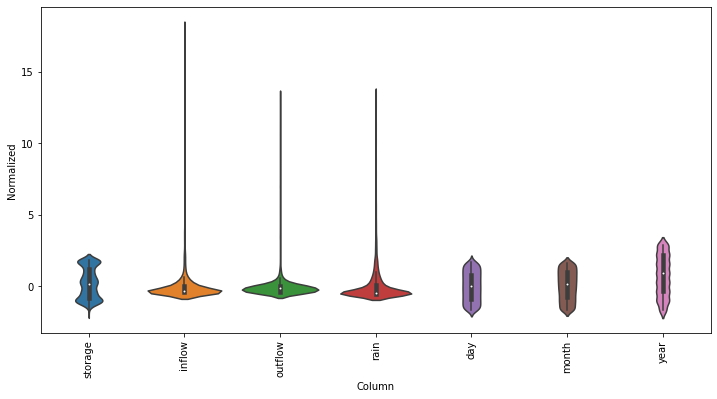

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
#Windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
#To-do: Change Parameters to test out which model works better
#Example:Past time-window: 60 days. Predict:30 days ahead. Label: storage
w1 = WindowGenerator(input_width=60, label_width=1, shift=30,
                     label_columns=['storage'])
w1

Total window size: 90
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [89]
Label column name(s): ['storage']

In [ ]:
#split window into inputs and labels
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 90, 7)
Inputs shape: (3, 60, 7)
labels shape: (3, 1, 1)


In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='storage', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time')

WindowGenerator.plot = plot

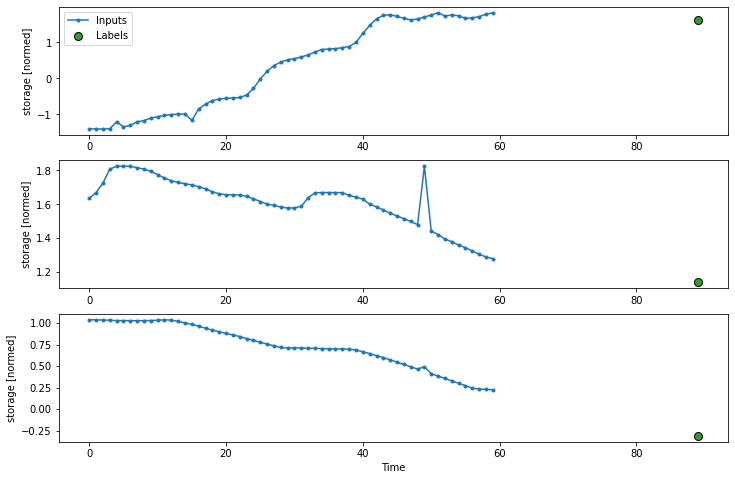

In [ ]:
w1.plot()

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
w1.train.element_spec

(TensorSpec(shape=(None, 60, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 60, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
LABEL_WIDTH = 1 #for longer plots
CONV_WIDTH = 60 # previous timesteps
CONV_SHIFT = 30 # predict timesteps ahead

wide_window = WindowGenerator(
    input_width=CONV_WIDTH, label_width=LABEL_WIDTH, shift=CONV_SHIFT,
    label_columns=['storage'])

wide_window

Total window size: 90
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [89]
Label column name(s): ['storage']

In [ ]:
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=CONV_SHIFT,
    label_columns=['storage'])

conv_window

Total window size: 90
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [89]
Label column name(s): ['storage']

In [ ]:
#To-do: add plots for multiple outputs (wide window function)
LABEL_WIDTH = 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=CONV_SHIFT,
    label_columns=['storage'])

wide_conv_window

Total window size: 90
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [89]
Label column name(s): ['storage']

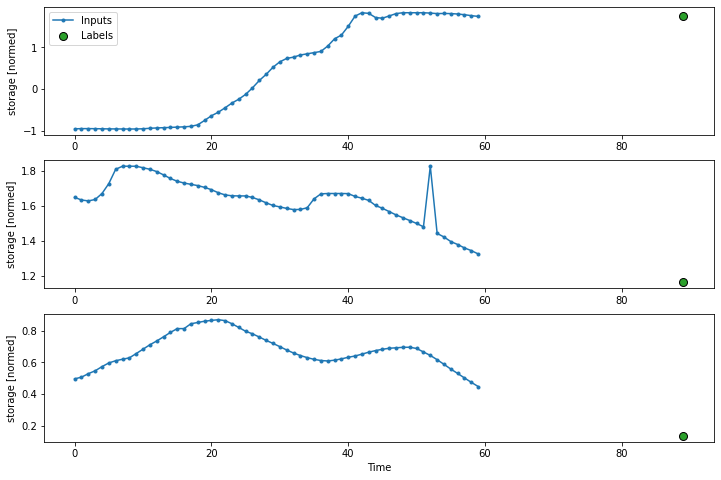

In [ ]:
wide_window.plot()

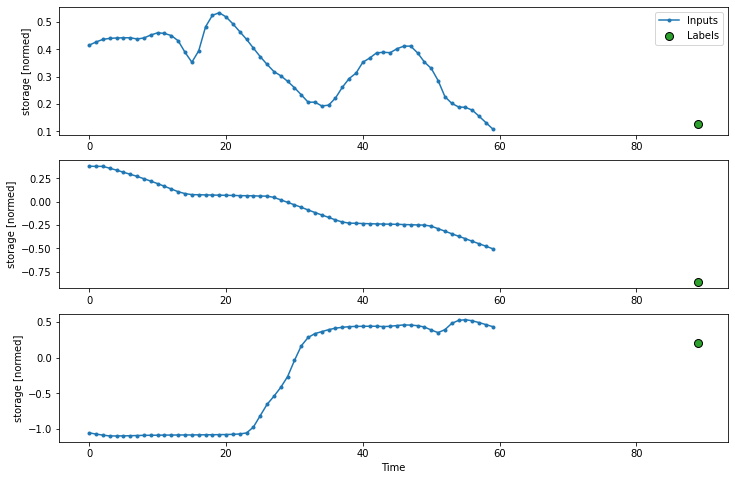

In [ ]:
conv_window.plot()

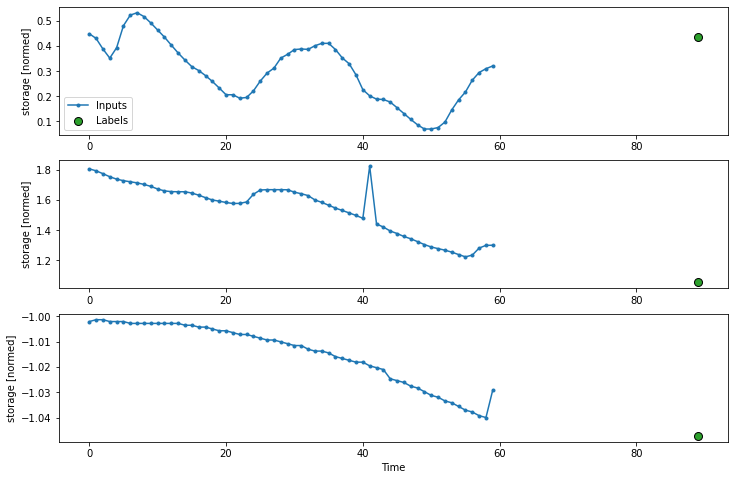

In [ ]:
wide_conv_window.plot()

In [ ]:
#to-do: build a baseline model (maybe simple auto-regressive model)
# build simpler models: linear, ARIMA, ...

# Various Models

In [ ]:

#common function for all models
MAX_EPOCHS = 40

val_performance = {}
performance = {}
patience = 8 # stops training if overfitting. dont set it too low.
def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError(), tf.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [ ]:
# # Model 0: ARIMA
# #!pip install pmdarima
# from pmdarima import auto_arima
  
# # Ignore harmless warnings
# import warnings
# warnings.filterwarnings("ignore")
  
# # Fit auto_arima function to AirPassengers dataset
# stepwise_fit = auto_arima(inputs['storage'], start_p = 1, start_q = 1,
#                           max_p = 3, max_q = 3, m = 12,
#                           start_P = 0, seasonal = True,
#                           d = None, D = 1, trace = True,
#                           error_action ='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings = True,  # we don't want convergence warnings
#                           stepwise = True)           # set to stepwise
  
# # To print the summary
# stepwise_fit.summary()


Best model:  ARIMA(2,0,0)(2,1,0)[12]          
Total fit time: 378.848 seconds

SARIMAX Results Dep. Variable: 	y 	No. Observations: 	3306
Model: 	SARIMAX(2, 0, 0)x(2, 1, 0, 12) 	Log Likelihood 	-6571.364
Date: 	Sat, 17 Jul 2021 	AIC 	13152.729
Time: 	04:08:47 	BIC 	13183.228
Sample: 	0 	HQIC 	13163.647
	- 3306 		
Covariance Type: 	opg 		
	coef 	std err 	z 	P>|z| 	[0.025 	0.975]
ar.L1 	0.6936 	0.002 	326.821 	0.000 	0.689 	0.698
ar.L2 	0.2822 	0.004 	72.697 	0.000 	0.275 	0.290
ar.S.L12 	-0.6670 	0.003 	-210.457 	0.000 	-0.673 	-0.661
ar.S.L24 	-0.3176 	0.003 	-98.993 	0.000 	-0.324 	-0.311
sigma2 	3.1570 	0.008 	381.105 	0.000 	3.141 	3.173
Ljung-Box (L1) (Q): 	0.12 	Jarque-Bera (JB): 	5238207.52
Prob(Q): 	0.73 	Prob(JB): 	0.00
Heteroskedasticity (H): 	0.17 	Skew: 	-4.50
Prob(H) (two-sided): 	0.00 	Kurtosis: 	198.15


Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

In [ ]:
# Model 1: multi-step dense. (Fully-connected NN)
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 60, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

15/15 [==============================] - 0s 3ms/step - loss: 0.4283 - mean_absolute_error: 0.4712 - mean_absolute_percentage_error: 392.9431 - root_mean_squared_error: 0.6545


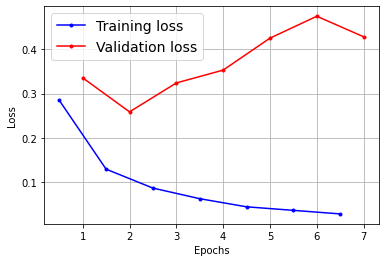

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
multi_step_dense.evaluate

<bound method Model.evaluate of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f28db655690>>

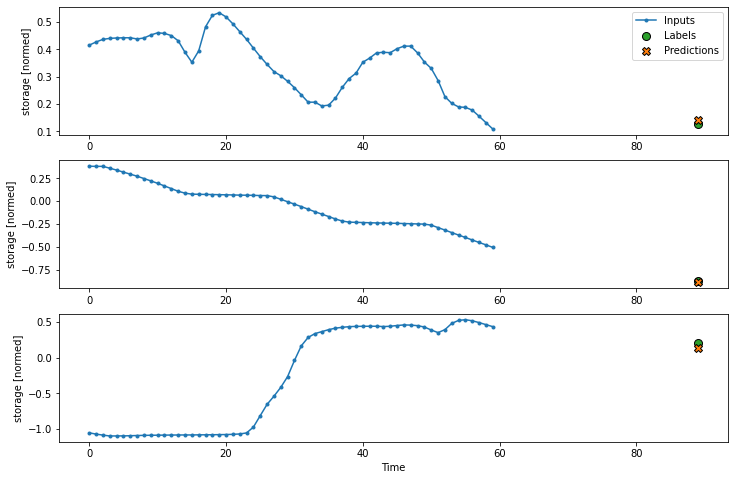

In [ ]:
conv_window.plot(multi_step_dense)

In [ ]:
#Model 2: Conv-dense. same model but more flexible for different input shapes.
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=(CONV_WIDTH,),activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 60, 7)
Output shape: (32, 1, 1)


15/15 [==============================] - 0s 4ms/step - loss: 0.4190 - mean_absolute_error: 0.4563 - mean_absolute_percentage_error: 77.9991 - root_mean_squared_error: 0.6473


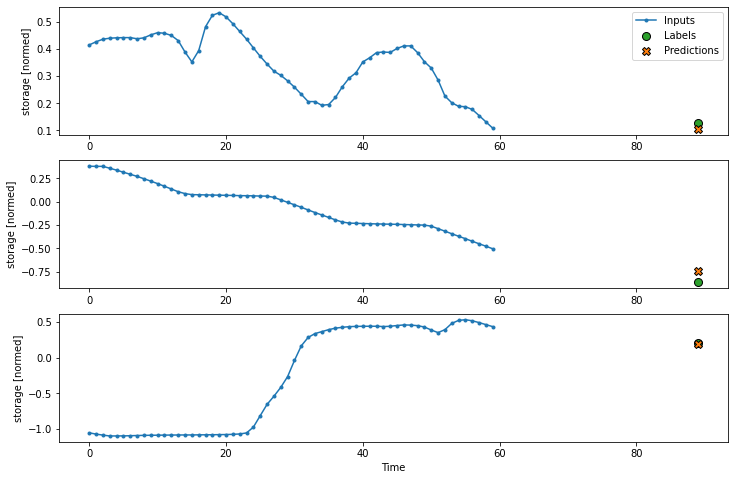

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

conv_window.plot(conv_model)

In [ ]:
#wide_conv_window.plot(conv_model)

In [ ]:
# Model 3: Recurrent Neural Network - LSTM (Simple)
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),#model outputs all intermediate predictions as well. If training a deep network, need this for all layers except the last
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_model(conv_window.example[0]).shape) #check output shape. should be (32, 1,1)

Input shape: (32, 60, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(lstm_model, conv_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(conv_window.val)
performance['LSTM'] = lstm_model.evaluate(conv_window.test, verbose=0)

15/15 [==============================] - 0s 4ms/step - loss: 0.5300 - mean_absolute_error: 0.5048 - mean_absolute_percentage_error: 196.2672 - root_mean_squared_error: 0.7280


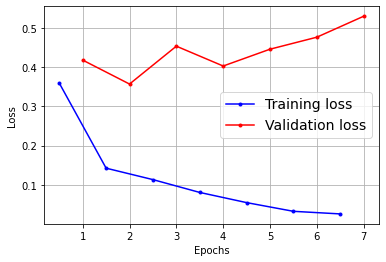

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
#wide_window.plot(lstm_model)

In [ ]:
# Model 4: LSTM with Residual connections. (IMPLEMENTED WRONGLY> SKIP IT.)
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Dense(1)  #dont know if last layer should be added  
]))


In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', residual_lstm(conv_window.example[0]).shape) #check output shape. should be (32, 1,1)


Input shape: (32, 60, 7)
Output shape: (32, 60, 7)


In [ ]:

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

15/15 [==============================] - 0s 5ms/step - loss: 2.3441 - mean_absolute_error: 1.1534 - mean_absolute_percentage_error: 865.3104 - root_mean_squared_error: 1.5310


In [ ]:
#take it deeper
#add layer norm
#add conv layer
#add dropout, recurrent_dropout. May also evaluate uncertainty using Monte-Carlo Dropout
#try WaveNet
#try bi-directional LSTM, GRU
#add cross-batch statefulness

In [ ]:
# Model 5: Deep LSTM
!pip install tensorflow_addons
import tensorflow_addons as tfa
lnLSTMCell = tfa.rnn.LayerNormLSTMCell(units=32) 


deep_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=CONV_WIDTH, strides=2, padding='valid'),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    #If using Dense layer at the end (which you should), remove return_sequences=True from second last layer
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

     |████████████████████████████████| 686kB 8.8MB/s 


In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', deep_lstm_model(conv_window.example[0]).shape)
#expected (32, 1, 1). It is because of return_sequences=True and Conv1D

Input shape: (32, 60, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(deep_lstm_model, conv_window)

IPython.display.clear_output()
val_performance['Deep_LSTM'] = deep_lstm_model.evaluate(conv_window.val)
performance['Deep_LSTM'] = deep_lstm_model.evaluate(conv_window.test, verbose=0)

15/15 [==============================] - 0s 5ms/step - loss: 0.6949 - mean_absolute_error: 0.7461 - mean_absolute_percentage_error: 663.6323 - root_mean_squared_error: 0.8336


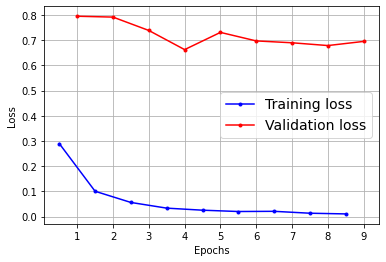

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
#Model 6: Deep LSTM with Conv; without Layer Normalization
deep_lstm_model_2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=CONV_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', deep_lstm_model_2(conv_window.example[0]).shape)


Input shape: (32, 60, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(deep_lstm_model_2, conv_window)

IPython.display.clear_output()
val_performance['Deep_LSTM_2'] = deep_lstm_model_2.evaluate(wide_window.val)
performance['Deep_LSTM_2'] = deep_lstm_model_2.evaluate(wide_window.test, verbose=0)

15/15 [==============================] - 0s 5ms/step - loss: 0.4144 - mean_absolute_error: 0.5365 - mean_absolute_percentage_error: 316.8770 - root_mean_squared_error: 0.6438


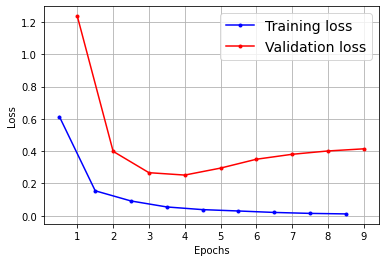

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
# Model 7: WaveNet
wavenet = tf.keras.models.Sequential()
wavenet.add(tf.keras.layers.InputLayer(input_shape=[None, 7]))# explicitly telling input shape. [None, #features]
for rate in (1, 2, 4, 8) * 2:
    wavenet.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
wavenet.add(tf.keras.layers.Conv1D(filters=10, kernel_size=1))

wavenet.add(tf.keras.layers.Dense(1))

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', wavenet(conv_window.example[0]).shape) #check shape. should be (32, 1, 1)

Input shape: (32, 60, 7)
Output shape: (32, 60, 1)


In [ ]:
history = compile_and_fit(wavenet, conv_window)

#IPython.display.clear_output()
val_performance['wavenet'] = wavenet.evaluate(conv_window.val)
performance['wavenet'] = wavenet.evaluate(conv_window.test, verbose=0)

Epoch 1/40
57/57 [==============================] - 2s 18ms/step - loss: 0.6599 - mean_absolute_error: 0.6690 - mean_absolute_percentage_error: 153.5354 - root_mean_squared_error: 0.8124 - val_loss: 0.9035 - val_mean_absolute_error: 0.7994 - val_mean_absolute_percentage_error: 324.0152 - val_root_mean_squared_error: 0.9505
Epoch 2/40
57/57 [==============================] - 1s 10ms/step - loss: 0.3094 - mean_absolute_error: 0.4060 - mean_absolute_percentage_error: 1074.1545 - root_mean_squared_error: 0.5562 - val_loss: 0.7670 - val_mean_absolute_error: 0.6808 - val_mean_absolute_percentage_error: 324.0255 - val_root_mean_squared_error: 0.8758
Epoch 3/40
57/57 [==============================] - 1s 10ms/step - loss: 0.2190 - mean_absolute_error: 0.3342 - mean_absolute_percentage_error: 1329.9110 - root_mean_squared_error: 0.4680 - val_loss: 1.2536 - val_mean_absolute_error: 0.8626 - val_mean_absolute_percentage_error: 476.3202 - val_root_mean_squared_error: 1.1197
Epoch 4/40
57/57 [=====

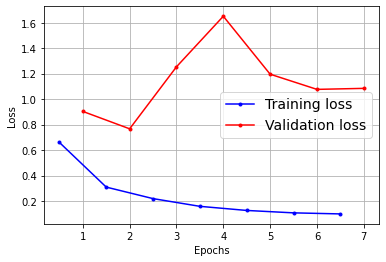

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
# Model 8: LSTM with dropout (becasue all the above models seem to overfit)
DROPOUT=0.2
RECURRENT_DROPOUT=0.2

deep_lstm_model_3 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=CONV_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', deep_lstm_model_3(conv_window.example[0]).shape)


Input shape: (32, 60, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(deep_lstm_model_3, conv_window)

IPython.display.clear_output()
val_performance['Deep_LSTM_3'] = deep_lstm_model_3.evaluate(conv_window.val)
performance['Deep_LSTM_3'] = deep_lstm_model_3.evaluate(conv_window.test, verbose=0)

15/15 [==============================] - 0s 5ms/step - loss: 0.4153 - mean_absolute_error: 0.5370 - mean_absolute_percentage_error: 397.1972 - root_mean_squared_error: 0.6445


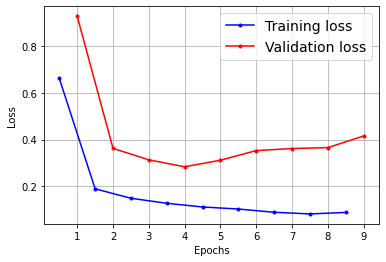

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
# Model 9: LSTM with dropout, conv, layer norm
#!pip install tensorflow_addons
import tensorflow_addons as tfa
lnLSTMCell = tfa.rnn.LayerNormLSTMCell(units=32, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT) 
deep_lstm_model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=CONV_WIDTH, strides=2, padding='valid'),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    #If using Dense layer at the end (which you should), remove return_sequences=True from second last layer
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', deep_lstm_model_4(conv_window.example[0]).shape)


Input shape: (32, 60, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(deep_lstm_model_4, conv_window)

IPython.display.clear_output()
val_performance['Deep_LSTM_4'] = deep_lstm_model_4.evaluate(conv_window.val)
performance['Deep_LSTM_4'] = deep_lstm_model_4.evaluate(conv_window.test, verbose=0)

15/15 [==============================] - 0s 5ms/step - loss: 0.2285 - mean_absolute_error: 0.3344 - mean_absolute_percentage_error: 249.7868 - root_mean_squared_error: 0.4780


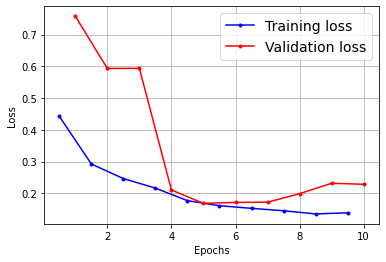

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

# Performance

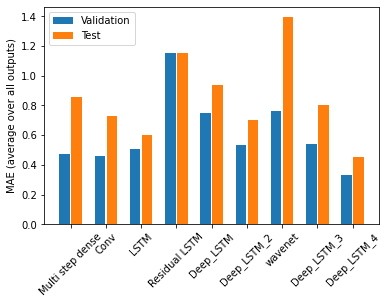

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

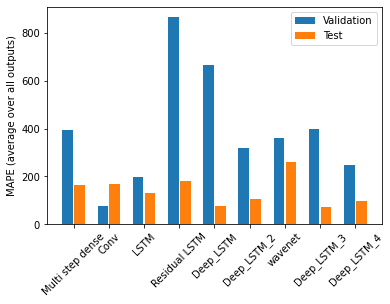

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_percentage_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_percentage_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAPE (average over all outputs)')
_ = plt.legend()

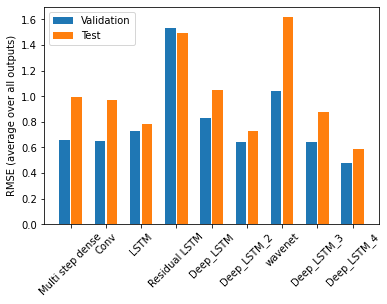

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'root_mean_squared_error'
metric_index = lstm_model.metrics_names.index('root_mean_squared_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('RMSE (average over all outputs)')
_ = plt.legend()

In [ ]:
#I thought Deep_LSTM_4 or wavenet would be best. Maybe need to try different hyperparameters.